In [7]:
import os
from pathlib import Path

from toolz import iterate

In [8]:
anal = os.path.abspath(os.path.join(os.getcwd(), "..", "analysis"))
anal

'/home/asevlad/program_files/github_asevlad/analysis'

In [9]:
coin = "AVAX"
file_path = os.path.join(anal, coin, "simple_detector", "plots_dfwash_general", "df_wash_general.csv")

In [10]:
import pandas as pd

pd.read_csv(file_path).columns

Index(['wallet_id', 'day', 'open_time', 'close_time', 'duration_s',
       'open_side', 'close_side', 'open_price', 'close_price',
       'price_change_pct', 'open_size', 'close_size', 'size_change_pct',
       'pairing_direction', 'pair_id', 'price1', 'size1', 'price2', 'size2',
       'side1', 'side2', 't1', 't2', 'delta_seconds', 'size_ratio',
       'direction', 'dt_s', 'size_err_pct', 'price_change_bps', 'same_price',
       'date', 'hour', 'dow'],
      dtype='object')

In [11]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "analysis"))


In [59]:
import numpy as np
import pandas as pd
from src.data_handler import CoinDataStore

def aggregate_coin_wash_data(token, analysis_path):
    """
    Aggregates wash trading metrics for ONE coin.
    Returns a dict with small, plot-ready objects.
    """

    # --- load wash trades ---
    df_wash = pd.read_csv(
        f"{analysis_path}/{token}/simple_detector/plots_dfwash_general/df_wash_general.csv",
        usecols=["open_size", "open_price"],
    )

    wash_volume = df_wash["open_size"].sum()
    wash_trade_count = len(df_wash) * 2

    # store sizes ONLY for distribution plots
    wash_sizes = df_wash["open_size"].values * df_wash["open_price"].values

    # --- load all trades (efficiently) ---
    store = CoinDataStore(token, engine="fastparquet")
    df_trades = store.load_all()

    # assume store.trades exists
    total_volume = df_trades["size"].sum()

    return {
        "coin": token,
        "total_volume": total_volume,
        "wash_volume": wash_volume,
        "wash_pct": wash_volume / total_volume if total_volume > 0 else 0.0,
        "wash_trade_count": wash_trade_count,
        "wash_sizes": wash_sizes,
    }


In [60]:
from tqdm import tqdm

analysis_path = os.path.abspath(os.path.join(os.getcwd(), "..", "analysis"))

coin_stats = []
wash_size_records = []

for token in tqdm(os.listdir(analysis_path)):
    try:
        agg = aggregate_coin_wash_data(token, analysis_path)
        coin_stats.append({
            k: agg[k]
            for k in ["coin", "total_volume", "wash_volume", "wash_pct", "wash_trade_count"]
        })

        wash_size_records.append(
            pd.DataFrame({
                "coin": token,
                "wash_size": agg["wash_sizes"]
            })
        )

    except Exception as e:
        print(f"Skipping {token}: {e}")


100%|██████████| 373/373 [00:37<00:00,  9.90it/s]


In [61]:
coin_stats = pd.DataFrame(coin_stats)
wash_sizes = pd.concat(wash_size_records, ignore_index=True)

/tmp/ipykernel_27994/491951176.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wash_sizes = pd.concat(wash_size_records, ignore_index=True)


In [62]:
coin_stats.sort_values("wash_pct")

,coin,total_volume,wash_volume,wash_pct,wash_trade_count
243,MEW,0.0,1.144086e+09,0.000000,30280
254,@95,0.0,1.500000e+04,0.000000,2
253,ALT,0.0,6.155519e+07,0.000000,28008
252,@5,0.0,3.758000e+01,0.000000,4
251,@67,0.0,1.086117e+04,0.000000,36
...,...,...,...,...,...
118,WLD,0.0,4.126472e+07,0.000000,77464
117,LDO,0.0,1.629285e+07,0.000000,32178
270,AVAX,81827144.0,2.368544e+06,0.028946,76728
341,ETH,96170928.0,5.668019e+06,0.058937,2802648


In [64]:
wash_sizes

,coin,wash_size
0,kFLOKI,18.218380
1,kFLOKI,19.441353
2,kFLOKI,17.708754
3,kFLOKI,15.310050
4,kFLOKI,19.468000
...,...,...
14823953,NEIROETH,38.890120
14823954,NEIROETH,39.149240
14823955,NEIROETH,38.763720
14823956,NEIROETH,50.039500


/tmp/ipykernel_27994/3612155724.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr")  # blue → red


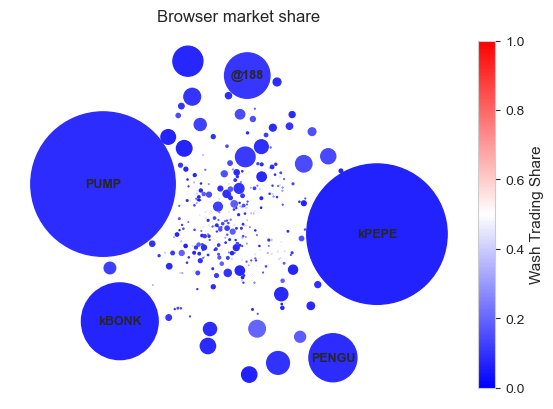

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

coin_stats["wash_pct"] = coin_stats["wash_volume"] / coin_stats["total_volume"]
wash_pct = coin_stats["wash_pct"].values

cmap = cm.get_cmap("bwr")  # blue → red
colors = cmap(wash_pct)  # RGBA array

bubble_data = {
    'coins': coin_stats["coin"],
    'total_volume': coin_stats["total_volume"],
    'color': colors
}


class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)


bubble_chart = BubbleChart(area=bubble_data['total_volume'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, bubble_data['coins'], bubble_data['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Browser market share')

sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Wash Trading Share", fontsize=11)

top_n = min(len(bubble_data["total_volume"]), 5)
top_idx = np.argsort(bubble_data["total_volume"])[-top_n:]

for i in top_idx:
    x, y = bubble_chart.bubbles[i, :2]
    ax.text(x, y, bubble_data["coins"][i],
            ha="center", va="center",
            fontsize=9, weight="bold")


plt.show()

# Distribution of the Trade Size in Wash Trades

In [66]:
coin_stats["volume_group"] = pd.qcut(
    coin_stats["total_volume"],
    q=5,
    labels=[f"G{i+1}" for i in range(5)]
)

wash_sizes = wash_sizes.merge(
    coin_stats[["coin", "volume_group"]],
    on="coin"
)

In [67]:
wash_sizes

,coin,wash_size,volume_group
0,kFLOKI,18.218380,G5
1,kFLOKI,19.441353,G5
2,kFLOKI,17.708754,G5
3,kFLOKI,15.310050,G5
4,kFLOKI,19.468000,G5
...,...,...,...
14823953,NEIROETH,38.890120,G5
14823954,NEIROETH,39.149240,G5
14823955,NEIROETH,38.763720,G5
14823956,NEIROETH,50.039500,G5


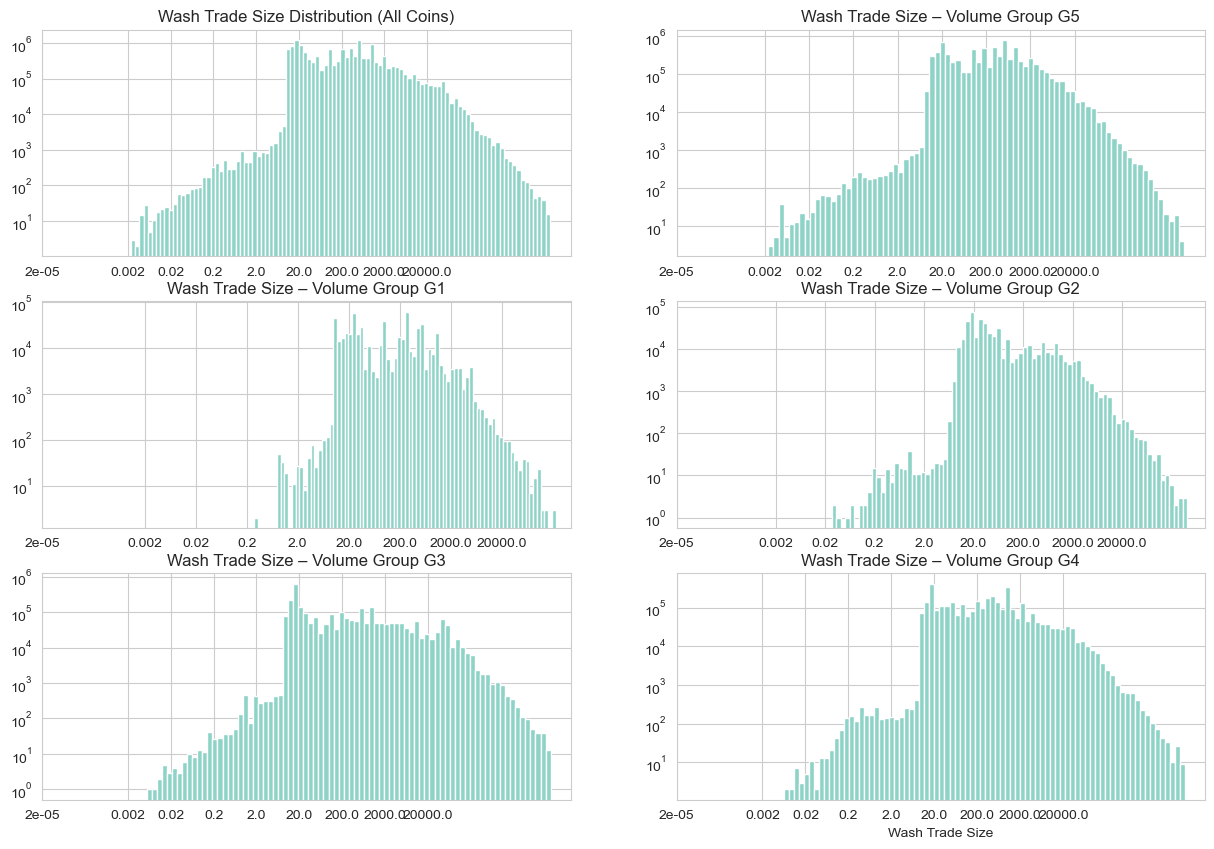

In [68]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

axes = axes.flatten()
real_ticks=[0.00002, 0.002, 0.02, 0.2, 2, 20, 200, 2000, 20000]

axes[0].hist(np.log(wash_sizes["wash_size"]), bins=100, log=True)
axes[0].set_title("Wash Trade Size Distribution (All Coins)")
axes[0].set_xticks(np.log(real_ticks))
axes[0].set_xticklabels(np.array(real_ticks).astype("str"))

for ax, g in zip(axes[1:], wash_sizes["volume_group"].dropna().unique()):
    data = wash_sizes[wash_sizes["volume_group"] == g]["wash_size"]
    ax.hist(np.log(data), bins=80, log=True)
    ax.set_title(f"Wash Trade Size – Volume Group {g}")


    ax.set_xticks(np.log(real_ticks))
    ax.set_xticklabels(np.array(real_ticks).astype("str"))

plt.xlabel("Wash Trade Size")
plt.show()


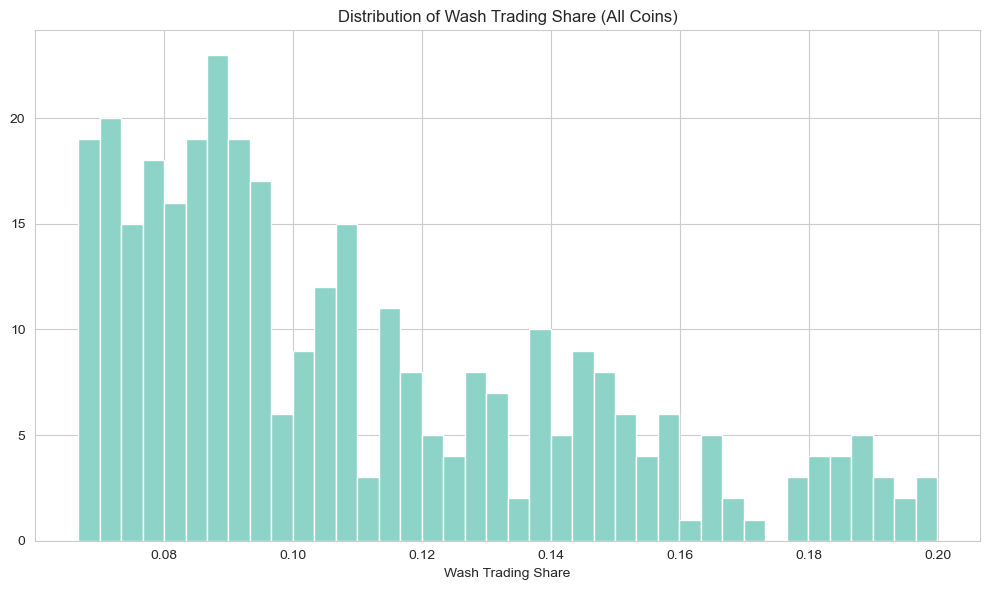

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(coin_stats["wash_pct"], bins=40)
plt.xlabel("Wash Trading Share")
plt.title("Distribution of Wash Trading Share (All Coins)")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

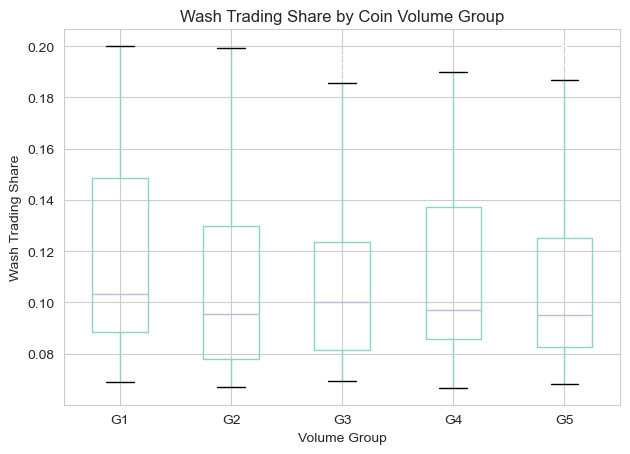

In [70]:
plt.figure(figsize=(12, 6))
coin_stats.boxplot(column="wash_pct", by="volume_group")
plt.suptitle("")
plt.xlabel("Volume Group")
plt.ylabel("Wash Trading Share")
plt.title("Wash Trading Share by Coin Volume Group")
plt.tight_layout()
plt.show()

In [84]:
def aggregate_coin_daily_volume(token, analysis_path, bin_days=1):
    # ---- wash trades ----
    df_wash = pd.read_csv(
        f"{analysis_path}/{token}/simple_detector/plots_dfwash_general/df_wash_general.csv",
        usecols=["open_time", "open_size", "open_price"]
    )

    df_wash["date"] = pd.to_datetime(df_wash["open_time"]).dt.floor("D")
    df_wash["wash_volume"] = df_wash["open_size"] * df_wash["open_price"]

    wash_daily = (
        df_wash.groupby("date")["wash_volume"]
        .sum()
        .reset_index()
    )

    # ---- all trades ----
    store = CoinDataStore(token, engine="fastparquet")
    df_trades = store.load_all()

    df_trades["date"] = pd.to_datetime(df_trades["time"]).dt.floor("D")
    df_trades["total_volume"] = df_trades["price"] * df_trades["size"]

    total_daily = (
        df_trades.groupby("date")["total_volume"]
        .sum()
        .reset_index()
    )

    # ---- merge ----
    df = total_daily.merge(
        wash_daily,
        on="date",
        how="left"
    ).fillna({"wash_volume": 0.0})

    # ---- optional 3-day binning ----
    if bin_days > 1:
        df["bin"] = (df["date"] - df["date"].min()).dt.days // bin_days
        df = (
            df.groupby("bin")[["total_volume", "wash_volume"]]
            .sum()
            .reset_index(drop=True)
        )

    df["coin"] = token
    return df

In [87]:
all_volume = []

for token in tqdm(os.listdir(analysis_path)):
    try:
        df_coin = aggregate_coin_daily_volume(
            token,
            analysis_path,
            bin_days=1  # ← change to 1 for daily
        )
        all_volume.append(df_coin)
    except Exception as e:
        print(f"Skipping {token}: {e}")

df_volume = pd.concat(all_volume, ignore_index=True)

100%|██████████| 373/373 [00:48<00:00,  7.74it/s]
/tmp/ipykernel_27994/2440809727.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_volume = pd.concat(all_volume, ignore_index=True)


In [88]:
df_volume

,date,total_volume,wash_volume,coin
0,2025-03-22,1.685516e+07,1.390984e+06,HYPE
1,2025-06-16,3.223535e+04,4.607872e+07,HYPE
2,2025-06-17,3.516669e+08,5.622411e+07,HYPE
3,2025-03-22,3.317161e+06,1.998506e+04,AVAX
4,2025-03-23,5.151370e+06,6.861624e+04,AVAX
...,...,...,...,...
254,2025-07-23,4.055827e+09,1.876498e+08,ETH
255,2025-07-24,4.659839e+09,2.766984e+08,ETH
256,2025-07-25,4.878774e+09,2.286454e+08,ETH
257,2025-07-26,1.847929e+09,8.125005e+07,ETH


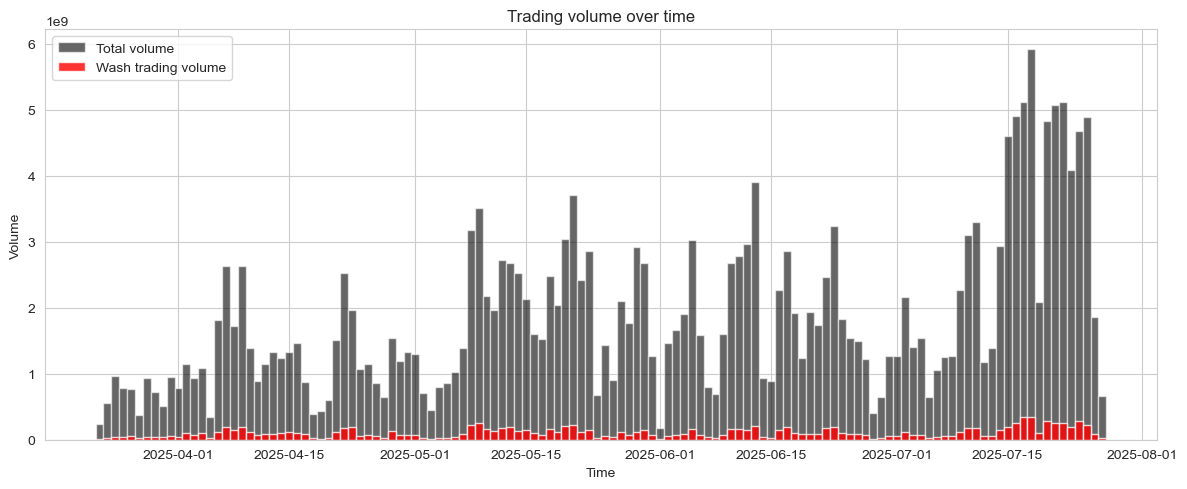

In [90]:
import matplotlib.pyplot as plt

df_plot = (
    df_volume
    .groupby("date", as_index=False)[["total_volume", "wash_volume"]]
    .sum()
)

plt.figure(figsize=(12, 5))

plt.bar(
    df_plot["date"],
    df_plot["total_volume"],
    width=1.0,
    color="black",
    alpha=0.6,
    label="Total volume"
)

plt.bar(
    df_plot["date"],
    df_plot["wash_volume"],
    width=1.0,
    color="red",
    alpha=0.8,
    label="Wash trading volume"
)

# plt.yscale("log")  # optional but recommended
plt.legend()
plt.xlabel("Time")
plt.ylabel("Volume")
plt.title("Trading volume over time")
plt.tight_layout()
plt.show()


In [107]:
df_coin_wash = (
    df_volume
    .groupby("coin", as_index=False)["wash_volume"]
    .sum()
    .sort_values("wash_volume", ascending=False)
)


In [108]:
TOP_K = 8

top = df_coin_wash.head(TOP_K)
other = pd.DataFrame({
    "coin": ["Other"],
    "wash_volume": [df_coin_wash["wash_volume"].iloc[TOP_K:].sum()]
})

df_donut = pd.concat([top, other], ignore_index=True)

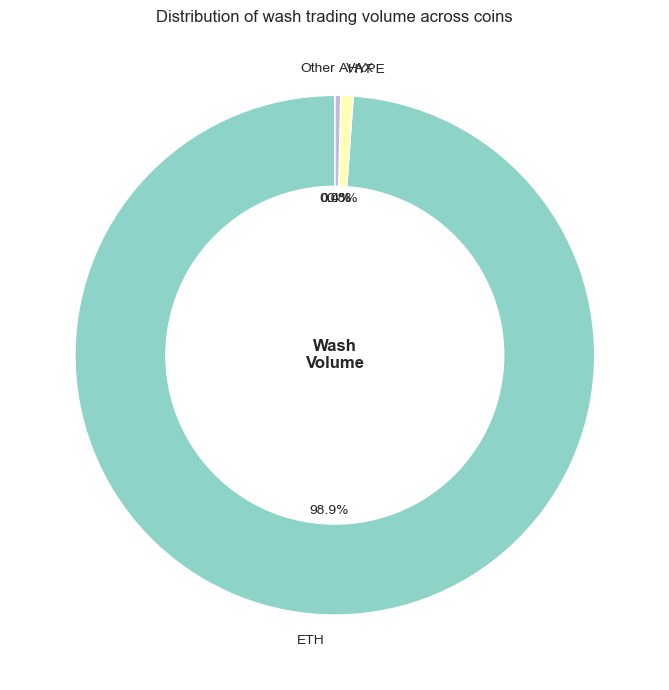

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, _ = ax.pie(
    df_donut["wash_volume"],
    labels=df_donut["coin"],
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    wedgeprops=dict(width=0.35)
)

ax.set_title("Distribution of wash trading volume across coins")

# center hole
ax.text(
    0, 0,
    "Wash\nVolume",
    ha="center",
    va="center",
    fontsize=12,
    fontweight="bold"
)

plt.tight_layout()
plt.show()
